In [260]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [483]:
%autoreload 2

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import xgboost as xgb
from src.utils import load_all_locations, load_all_vals, load_val
from src.utils.data_loader import load_val_dates

from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.utils.validation import check_is_fitted

# Torch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader


sns.set_theme(style="darkgrid")

In [262]:
data = load_all_locations()

In [930]:
data[0].columns

Index(['time', 'absolute_humidity_2m:gm3', 'air_density_2m:kgm3',
       'ceiling_height_agl:m', 'clear_sky_energy_1h:J', 'clear_sky_rad:W',
       'cloud_base_agl:m', 'dew_or_rime:idx', 'dew_point_2m:K',
       'diffuse_rad:W', 'diffuse_rad_1h:J', 'direct_rad:W', 'direct_rad_1h:J',
       'effective_cloud_cover:p', 'elevation:m', 'fresh_snow_12h:cm',
       'fresh_snow_1h:cm', 'fresh_snow_24h:cm', 'fresh_snow_3h:cm',
       'fresh_snow_6h:cm', 'is_day:idx', 'is_in_shadow:idx',
       'msl_pressure:hPa', 'precip_5min:mm', 'precip_type_5min:idx',
       'pressure_100m:hPa', 'pressure_50m:hPa', 'prob_rime:p',
       'rain_water:kgm2', 'relative_humidity_1000hPa:p', 'sfc_pressure:hPa',
       'snow_density:kgm3', 'snow_depth:cm', 'snow_drift:idx',
       'snow_melt_10min:mm', 'snow_water:kgm2', 'sun_azimuth:d',
       'sun_elevation:d', 'super_cooled_liquid_water:kgm2', 't_1000hPa:K',
       'total_cloud_cover:p', 'visibility:m', 'wind_speed_10m:ms',
       'wind_speed_u_10m:ms', 'wind_sp

<Axes: >

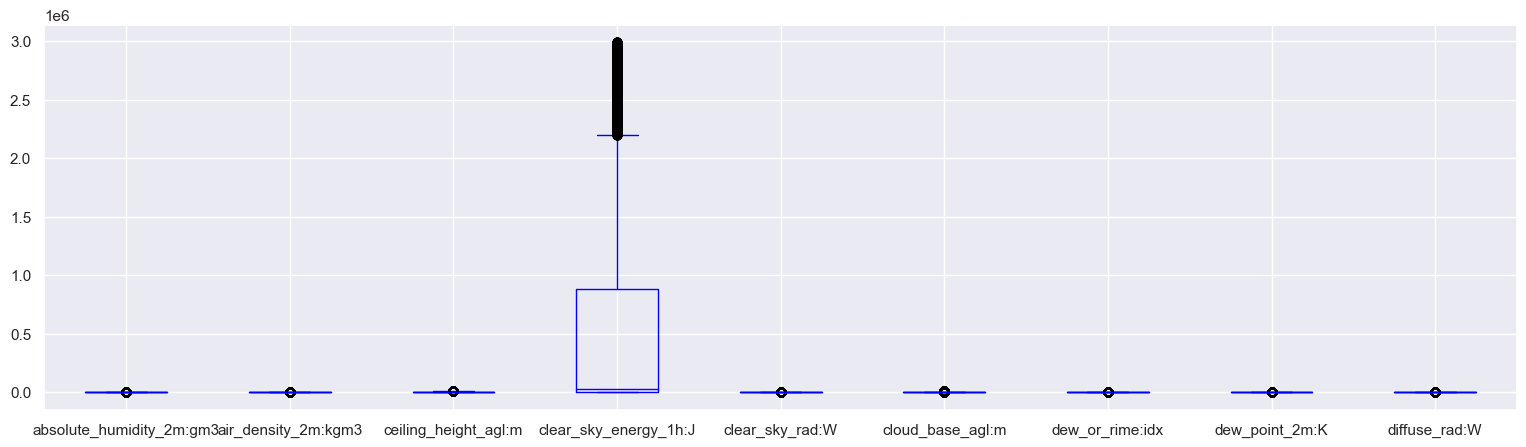

In [932]:
data[0][['time', 'absolute_humidity_2m:gm3', 'air_density_2m:kgm3',
       'ceiling_height_agl:m', 'clear_sky_energy_1h:J', 'clear_sky_rad:W',
       'cloud_base_agl:m', 'dew_or_rime:idx', 'dew_point_2m:K',
       'diffuse_rad:W']].boxplot(rot='horizontal', color='blue',figsize=(19, 5))

In [263]:
def create_time_features(df):
    df['hour'] = df.time.dt.hour
    df['dayofmonth'] = df.time.dt.day
    df['dayofweek'] = df.time.dt.dayofweek
    df['quarter'] = df.time.dt.quarter
    df['month'] = df.time.dt.month
    df['year'] = df.time.dt.year
    df['dayofyear'] = df.time.dt.dayofyear
    return df

In [888]:
features = [
    "direct_rad:W",
    "hour",
    "dayofmonth",
    "dayofweek",
    "quarter",
    "month",
    "year",
    "dayofyear",
]

In [889]:
class DatasetPreparer:
    def __init__(self, n_steps):
        self.X_scaler = MinMaxScaler()
        self.y_scalerA = MinMaxScaler()
        self.y_scalerB = MinMaxScaler()
        self.y_scalerC = MinMaxScaler()
        self.n_steps = n_steps

    def _is_fit_called(self):
        return (
            hasattr(self.X_scaler, "n_features_in_")
            and hasattr(self.y_scalerA, "n_features_in_")
            and hasattr(self.y_scalerB, "n_features_in_")
            and hasattr(self.y_scalerC, "n_features_in_")
        )

    def _fit_by_location(self, y_df):
        self.y_scalerA = self.y_scalerA.fit(y_df[y_df.location == "A"][["y"]])
        # self.y_scalerB = self.y_scalerB.fit(y_df[y_df.location == "B"][["y"]])
        # self.y_scalerC = self.y_scalerC.fit(y_df[y_df.location == "C"][["y"]])

    def _scale_by_location(self, y_df):
        if "A" in list(y_df.location):
            y_df.loc[y_df.location == "A", "y"] = self.y_scalerA.transform(
                y_df[y_df.location == "A"][["y"]]
            )
        # if "B" in list(y_df.location):
        #     y_df.loc[y_df.location == "B", "y"] = self.y_scalerB.transform(
        #         y_df[y_df.location == "B"][["y"]]
        #     )
        # if "C" in list(y_df.location):
        #     y_df.loc[y_df.location == "C", "y"] = self.y_scalerC.transform(
        #         y_df[y_df.location == "C"][["y"]]
        #     )

        return y_df["y"]
    
    def inverse_scale_by_location(self, y_df):
        if "A" in list(y_df.location):
            y_df.loc[y_df.location == "A", "y"] = self.y_scalerA.inverse_transform(
                y_df[y_df.location == "A"][["y"]]
            )
        # if "B" in list(y_df.location):
        #     y_df.loc[y_df.location == "B", "y"] = self.y_scalerB.inverse_transform(
        #         y_df[y_df.location == "B"][["y"]]
        #     )
        # if "C" in list(y_df.location):
        #     y_df.loc[y_df.location == "C", "y"] = self.y_scalerC.inverse_transform(
        #         y_df[y_df.location == "C"][["y"]]
        #     )

        return y_df

    def prepare(self, X_df, y_df):
        df = X_df.copy()
        y_df = y_df.copy()

        # Drop missing column values
        nan_columns = df.columns[df.isna().any()].tolist()
        df = df.drop(columns=nan_columns)

        # One-hot Encoding
        df = df.reset_index().drop(columns="index")
        one_hot = pd.get_dummies(df["location"]).astype(int)
        df = df.drop("location", axis=1)
        df = pd.merge(df, one_hot, left_index=True, right_index=True)

        # Add time based features
        df = create_time_features(df)

        for location in ("A", "B", "C"):
            if not location in df.columns:
                df[location] = 0

        df = df[features]

        # Scaling
        if not self._is_fit_called():
            self.X_scaler = self.X_scaler.fit(df)
            self._fit_by_location(y_df)

        X_as_array = self.X_scaler.transform(df)
        y_as_array = np.array(self._scale_by_location(y_df))

        X = []
        y = []

        if self.n_steps == 0:
            return X_as_array, y_as_array
        
        for i in range(len(X_as_array) - self.n_steps):
            row = [a for a in X_as_array[i : i + self.n_steps]]
            X.append(row)
            label = y_as_array[i + self.n_steps]
            y.append(label)

        return np.array(X), np.array(y)

In [890]:
# Simulate Kaggle validation set

vals = load_all_vals()
vals["test"] = np.where(vals["absolute_humidity_2m:gm3"].isna(), 0, 1)
vals["test2"] = np.where(vals["absolute_humidity_2m:gm3"].isna(), 0.1, 0.9)

val_dates = pd.DataFrame(columns=["time"], data=load_val_dates())
val_dates.time = pd.to_datetime(val_dates.time)

# Get dates of our validation set, offset in order to get the correct test-set timeframe
test_dates = val_dates.copy()
test_dates = test_dates - pd.DateOffset(days=64)

In [913]:
test_size = 1000
window_size = 0

X_data_train = data[0][(data[0].set_type == "TRAIN") & (data[0].location == "A")].iloc[
    :-test_size
]
y_data_train = data[1][(data[1].set_type == "TRAIN") & (data[1].location == "A")].iloc[
    :-test_size
]

X_data_test = data[0][(data[0].set_type == "TRAIN") & (data[0].location == "A")].iloc[
    -test_size:
]
y_data_test = data[1][(data[1].set_type == "TRAIN") & (data[1].location == "A")].iloc[
    -test_size:
]
X_data_val = data[0][(data[0].set_type == "TEST") & data[0].time.isin(test_dates.time)]
y_data_val = data[1][(data[1].set_type == "TEST") & data[1].time.isin(test_dates.time)]

preparer = DatasetPreparer(n_steps=window_size)

X_train, y_train = preparer.prepare(X_data_train, y_data_train)
X_test, y_test = preparer.prepare(X_data_test, y_data_test)
X_val, y_val = preparer.prepare(X_data_val, y_data_val)

print(
    "TRAIN:",
    X_train.shape,
    y_train.shape,
    "\nTEST:",
    X_test.shape,
    y_test.shape,
    "\nVAL:",
    X_val.shape,
    y_val.shape,
)

TRAIN: (28625, 8) (28625,) 
TEST: (1000, 8) (1000,) 
VAL: (2043, 8) (2043,)


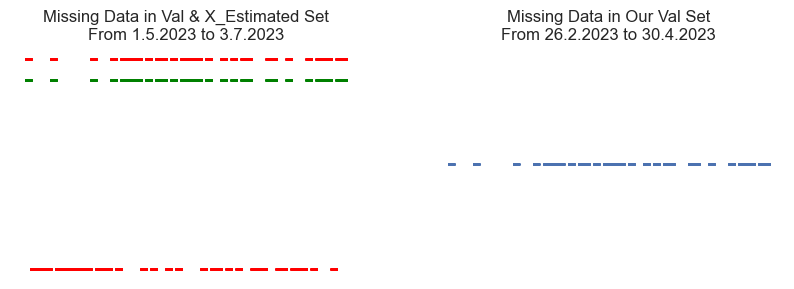

In [914]:
plot_data = y_data_val.copy()

fig, ax = plt.subplots(1, 2, figsize=(10, 3))

ax[0].scatter(vals["time"], vals["test"], s=1, c="red")
ax[0].scatter(
    vals[vals.time.isin(load_val_dates())]["time"],
    vals[vals.time.isin(load_val_dates())]["test2"],
    s=1,
    c="green",
)
ax[1].scatter(plot_data.time, plot_data.shape[0] * [1], s=1)
ax[0].set_title(
    f"Missing Data in Val & X_Estimated Set\nFrom {vals.time.min().day}.{vals.time.min().month}.{vals.time.min().year} to {vals.time.max().day}.{vals.time.max().month}.{vals.time.max().year}"
)
ax[1].set_title(f"Missing Data in Our Val Set\nFrom {plot_data.time.min().day}.{plot_data.time.min().month}.{plot_data.time.min().year} to {plot_data.time.max().day}.{plot_data.time.max().month}.{plot_data.time.max().year}")
ax[0].set_axis_off()
ax[1].set_axis_off()

In [915]:
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]
    
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([28625, 8]),
 torch.Size([1000, 8]),
 torch.Size([28625]),
 torch.Size([1000]))

In [916]:
# CONSTANTS

batch_size = 30
input_size = X_train.shape[1] if window_size == 0 else X_train.shape[2]
hidden_size = 40
num_stacked_layers = 1

In [917]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [918]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, 
                            batch_first=True)
        
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # batch_size = x.size(0)
        # h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to("cpu")
        # c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to("cpu")
        
        # out, _ = self.lstm(x, (h0, c0))
        # out = self.fc(out[:, -1, :])
        # return out
        lstm_out, _ = self.lstm(x.view(len(x), 1, -1))
        output = self.fc(lstm_out.view(len(x), -1))
        return output

model = LSTM(input_size, hidden_size, num_stacked_layers)
model.to("cpu")
model

LSTM(
  (lstm): LSTM(8, 40, batch_first=True)
  (fc): Linear(in_features=40, out_features=1, bias=True)
)

In [919]:
learning_rate = 0.01
num_epochs = 10
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [920]:
def train_one_epoch(epoch):
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0
    
    for batch_index, batch in enumerate(train_loader):
        X_batch, y_batch = batch[0].to("cpu"), batch[1].to("cpu")

        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        running_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0
    print()

In [921]:
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0
    
    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to("cpu"), batch[1].to("cpu")
        
        with torch.no_grad():
            output = model(x_batch)
            loss = criterion(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)
    
    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

In [922]:
for epoch in range(num_epochs):
    train_one_epoch(epoch)
    validate_one_epoch()

Epoch: 1
Batch 100, Loss: 0.159


/Users/mathiasraa/anaconda3/envs/forecasting/lib/python3.10/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([30])) that is different to the input size (torch.Size([30, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Batch 200, Loss: 0.029
Batch 300, Loss: 0.133
Batch 400, Loss: 0.160
Batch 500, Loss: 0.022
Batch 600, Loss: 0.165
Batch 700, Loss: 0.139
Batch 800, Loss: 0.015
Batch 900, Loss: 0.171

Val Loss: 0.109
***************************************************

Epoch: 2
Batch 100, Loss: 0.157
Batch 200, Loss: 0.028


/Users/mathiasraa/anaconda3/envs/forecasting/lib/python3.10/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([5])) that is different to the input size (torch.Size([5, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/Users/mathiasraa/anaconda3/envs/forecasting/lib/python3.10/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Batch 300, Loss: 0.133
Batch 400, Loss: 0.160
Batch 500, Loss: 0.022
Batch 600, Loss: 0.165
Batch 700, Loss: 0.139
Batch 800, Loss: 0.014
Batch 900, Loss: 0.171

Val Loss: 0.108
***************************************************

Epoch: 3
Batch 100, Loss: 0.157
Batch 200, Loss: 0.028
Batch 300, Loss: 0.133
Batch 400, Loss: 0.160
Batch 500, Loss: 0.021
Batch 600, Loss: 0.165
Batch 700, Loss: 0.138
Batch 800, Loss: 0.014
Batch 900, Loss: 0.171

Val Loss: 0.108
***************************************************

Epoch: 4
Batch 100, Loss: 0.157
Batch 200, Loss: 0.027
Batch 300, Loss: 0.133
Batch 400, Loss: 0.160
Batch 500, Loss: 0.022
Batch 600, Loss: 0.165
Batch 700, Loss: 0.138
Batch 800, Loss: 0.014
Batch 900, Loss: 0.171

Val Loss: 0.108
***************************************************

Epoch: 5
Batch 100, Loss: 0.157
Batch 200, Loss: 0.028
Batch 300, Loss: 0.133
Batch 400, Loss: 0.160
Batch 500, Loss: 0.022
Batch 600, Loss: 0.164
Batch 700, Loss: 0.138
Batch 800, Loss: 0.013
Batc

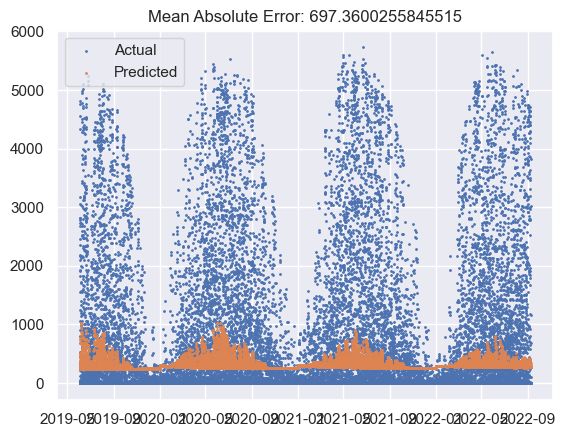

In [926]:
with torch.no_grad():
    predicted = model(X_train.to("cpu")).to("cpu").numpy()

prediction_df = y_data_train.copy().iloc[:]
prediction_df["y"] = predicted
prediction_df = preparer.inverse_scale_by_location(prediction_df)

actual = data[1][(data[1].set_type == "TRAIN") & (data[1].location == "A")].iloc[
    :-test_size,
]

plt.scatter(actual.iloc[:].time, actual.iloc[:].y, label="Actual",  s=1)
plt.scatter(
    prediction_df.time,
    prediction_df.y,
    label="Predicted",
    s=1
)
plt.title(
    "Mean Absolute Error: "
    + str(
        mean_absolute_error(
            actual.iloc[:].y,
            prediction_df["y"],
        )
    )
)
plt.legend()
plt.show()

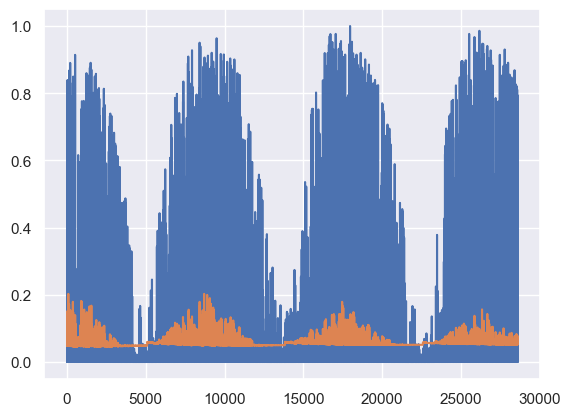

In [927]:
plt.plot(y_train)
plt.plot(predicted)

In [ ]:
np.corrcoef(actual.iloc[:].y, prediction_df.y)

array([[1.        , 0.69993237],
       [0.69993237, 1.        ]])

In [ ]:
np.corrcoef(actual.iloc[:].y, X_data_train["direct_rad:W"])

array([[1.        , 0.86408823],
       [0.86408823, 1.        ]])